In [1]:
# open up the data and display
import pandas as pd
import re
import random
import requests

In [8]:
def download_feedback_data(model_id): 
    """
    Get data from the feedback module per model ID
    and return it in a format that can be used directly in training data. 
    TODO: in the future we should check the minimum length of a feedback text, 
    and whether it exists in the training or test data. 
    """
    feedback = requests.get(f'http://127.0.0.1/feedback/').json()
    fb_list = []
    for f in feedback: 
        fb_dict = dict()
        fb_dict['description'] = aggressively_clean_text(f['text'])
        fb_dict['genre'] = '__label__' + f['label']
        fb_list.append(fb_dict)

    df = pd.DataFrame(fb_list)
    return df

In [9]:
feedback_df = download_feedback_data(None)
print(feedback_df)

                              description              genre
0                it was the best of times  __label__classics
1  it is a truth universally acknowledged  __label__classics


In [10]:
df = pd.read_csv('/Users/sumi/projects/kaggle-google-books/google-books-dataset/google_books_1299.csv')
def cleanup(df): 
    # clean up columns, save only what we need
    df = df.drop(['Unnamed: 0', 'voters', 'ISBN', 'language', 'published_date', 'publisher', 'price', 'currency'],
              axis=1)
    df = df.rename(columns={'generes': 'genres'})
    # use only those entries with genres
    total_length = len(df)
    genre_df = df[df['genres'] != 'none']
    genre_rows = len(genre_df) 
    print(f'Total length is {total_length} but genre rows are {genre_rows}')
    return genre_df

In [11]:
genre_df = cleanup(df)
genre_df.head()

Total length is 1299 but genre rows are 772


,title,author,rating,description,page_count,genres
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,Determined to make a new start in her quaint h...,288,"Fiction , Mystery &amp, Detective , Cozy , Gen..."
2,The Art of Super Mario Odyssey,Nintendo,3.9,Take a globetrotting journey all over the worl...,368,"Games &amp, Activities , Video &amp, Electronic"
4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,The stunning debut fantasy novel from author P...,544,"Fiction , Fantasy , Dark Fantasy"
6,God of War: The Official Novelization,J.M. Barlog,4.5,The novelization of the highly anticipated God...,400,"Fiction , Media Tie-In"
7,Edgedancer: From the Stormlight Archive,Brandon Sanderson,4.8,From #1 New York Times bestselling author Bran...,226,"Fiction , Fantasy , Epic"


In [12]:
def split_genres(df): 
    df[['genre_1', 'genre_2', 'genre_3', 'genre_4']] = df.genres.str.split(' , ', expand=True)
    df = df.drop(['genres'], axis=1)
    return df

In [13]:
def genre_choose(df_split):
    """
    # We could try a couple things here:
     we can first assume that genre_1 is the closest genre
     to what's really going on.
     Then we'll see how many unique values are here,
     because lots of things are marked "fiction".
     This was a great place to try streamlit.
    :return:
    """
    genre_split = split_genres(df_split)
    genre_2_split = genre_split.drop(['genre_1', 'genre_3', 'genre_4'], axis=1).rename(columns={'genre_2': 'genre'})

    return genre_2_split

In [14]:
gen_df = genre_choose(genre_df)
gen_df.head()

,title,author,rating,description,page_count,genre
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,Determined to make a new start in her quaint h...,288,"Mystery &amp, Detective"
2,The Art of Super Mario Odyssey,Nintendo,3.9,Take a globetrotting journey all over the worl...,368,"Video &amp, Electronic"
4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,The stunning debut fantasy novel from author P...,544,Fantasy
6,God of War: The Official Novelization,J.M. Barlog,4.5,The novelization of the highly anticipated God...,400,Media Tie-In
7,Edgedancer: From the Stormlight Archive,Brandon Sanderson,4.8,From #1 New York Times bestselling author Bran...,226,Fantasy


### Now we'll have to do some cleanup and sample correctly

In [15]:
gen_df['genre'].unique()

array(['Mystery &amp, Detective', 'Video &amp, Electronic', 'Fantasy',
       'Media Tie-In', 'Medical (incl. Patients)', 'Superheroes',
       'Sports', 'Science Fiction', 'Women', 'Humorous Stories',
       'Classics', 'Motivational', 'General', 'Noir', 'Leadership',
       'Accounting', 'Methods', 'Letters', 'Literary', 'Thrillers',
       'Industries', 'Personal Growth', 'Marketing', 'Management',
       'Corporate Finance', 'Crime', 'Interpersonal Relations',
       'Personal Success', 'Communication &amp, Social Skills',
       'Fantasy &amp, Magic', 'Personal Finance', 'Shakespeare', 'Soccer',
       'Modern', 'Humorous', 'Action &amp, Adventure',
       'Mystery & Detective', 'New Business Enterprises',
       'Self-Management', 'Horror', 'LGBT', 'Emotions', 'Reference',
       'Economics', 'Action & Adventure', 'Manga',
       'Organizational Behavior', 'Conflict Resolution &amp, Mediation',
       'Mentoring & Coaching', 'Military', 'Advertising &amp, Promotion',
       'Nonf

# Now it's training time, just with the description

In [16]:
relevant_cols = ['description']
label_col = 'genre'

In [17]:
def aggressively_clean_text(t):
    t = t.lower()
    t = re.sub(r"\W", ' ', t)
    return t

In [18]:
def aggressively_clean_label(t): 
    t = re.sub(r"&amp,", '&', t)
    t = re.sub(r"[\( | \) | \&]", ' ', t)
    t = re.sub(r"\s", '_', t)

    t = t.lower()
    t = '__label__' + t
    return t

In [19]:
genre_labels = gen_df[label_col].apply(aggressively_clean_label)
cleaned_descr = gen_df['description'].apply(aggressively_clean_text)
cleaned_descr.head()

1    determined to make a new start in her quaint h...
2    take a globetrotting journey all over the worl...
4    the stunning debut fantasy novel from author p...
6    the novelization of the highly anticipated god...
7    from  1 new york times bestselling author bran...
Name: description, dtype: object

In [20]:
genre_labels.head()

1    __label__mystery___detective
2     __label__video___electronic
4                __label__fantasy
6           __label__media_tie-in
7                __label__fantasy
Name: genre, dtype: object

In [21]:
cleaned_full_df = pd.DataFrame.merge(gen_df, genre_labels, left_index=True, right_index=True)
cleaned_full_df.head()

,title,author,rating,description,page_count,genre_x,genre_y
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,Determined to make a new start in her quaint h...,288,"Mystery &amp, Detective",__label__mystery___detective
2,The Art of Super Mario Odyssey,Nintendo,3.9,Take a globetrotting journey all over the worl...,368,"Video &amp, Electronic",__label__video___electronic
4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,The stunning debut fantasy novel from author P...,544,Fantasy,__label__fantasy
6,God of War: The Official Novelization,J.M. Barlog,4.5,The novelization of the highly anticipated God...,400,Media Tie-In,__label__media_tie-in
7,Edgedancer: From the Stormlight Archive,Brandon Sanderson,4.8,From #1 New York Times bestselling author Bran...,226,Fantasy,__label__fantasy


In [22]:
cleaned_df = pd.DataFrame.merge(cleaned_full_df, cleaned_descr, left_index=True, right_index=True)
cleaned_df.head()

,title,author,rating,description_x,page_count,genre_x,genre_y,description_y
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,Determined to make a new start in her quaint h...,288,"Mystery &amp, Detective",__label__mystery___detective,determined to make a new start in her quaint h...
2,The Art of Super Mario Odyssey,Nintendo,3.9,Take a globetrotting journey all over the worl...,368,"Video &amp, Electronic",__label__video___electronic,take a globetrotting journey all over the worl...
4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,The stunning debut fantasy novel from author P...,544,Fantasy,__label__fantasy,the stunning debut fantasy novel from author p...
6,God of War: The Official Novelization,J.M. Barlog,4.5,The novelization of the highly anticipated God...,400,Media Tie-In,__label__media_tie-in,the novelization of the highly anticipated god...
7,Edgedancer: From the Stormlight Archive,Brandon Sanderson,4.8,From #1 New York Times bestselling author Bran...,226,Fantasy,__label__fantasy,from 1 new york times bestselling author bran...


In [23]:
cleaned_df = cleaned_df.drop(['genre_x', 'description_x'], axis=1).rename(columns={'description_y': 'description', 'genre_y': 'genre'})
cleaned_df.head()

,title,author,rating,page_count,genre,description
1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,288,__label__mystery___detective,determined to make a new start in her quaint h...
2,The Art of Super Mario Odyssey,Nintendo,3.9,368,__label__video___electronic,take a globetrotting journey all over the worl...
4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,544,__label__fantasy,the stunning debut fantasy novel from author p...
6,God of War: The Official Novelization,J.M. Barlog,4.5,400,__label__media_tie-in,the novelization of the highly anticipated god...
7,Edgedancer: From the Stormlight Archive,Brandon Sanderson,4.8,226,__label__fantasy,from 1 new york times bestselling author bran...


In [27]:
final_df = pd.concat([cleaned_df, feedback_df], ignore_index=True)
print(final_df)

                                                 title             author  \
0     Antiques Roadkill: A Trash 'n' Treasures Mystery      Barbara Allan   
1                       The Art of Super Mario Odyssey           Nintendo   
2            The Painted Man (The Demon Cycle, Book 1)     Peter V. Brett   
3                God of War: The Official Novelization        J.M. Barlog   
4              Edgedancer: From the Stormlight Archive  Brandon Sanderson   
..                                                 ...                ...   
769  Twas The Nightshift Before Christmas: Festive ...           Adam Kay   
770  Why We Sleep: The New Science of Sleep and Dreams     Matthew Walker   
771           W is for Wasted: A Kinsey Millhone Novel        Sue Grafton   
772                                                NaN                NaN   
773                                                NaN                NaN   

     rating  page_count                                      genre  \
0    

In [36]:
data_labels = cleaned_df['genre'] + ' ' + cleaned_df['description']
train_percentage = 0.8
test_percentage = 1.0 - train_percentage

## Make train/test split

In [37]:
train_data = data_labels.sample(frac=train_percentage).to_csv('train_genre.txt', header=False, index=False)
test_df = data_labels.sample(frac=test_percentage).to_csv('test_genre.txt', header=False, index=False)

# Train fasttext model

In [38]:
import fasttext
model = fasttext.train_supervised('train_genre.txt')
for i in range(4): 
    samples, precision, recall = model.test('test_genre.txt', k=i+1)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Top n: {i+1} Samples: {samples} Precision: {precision} Recall: {recall} F1: {f1_score}")

Top n: 1 Samples: 153 Precision: 0.1830065359477124 Recall: 0.1830065359477124 F1: 0.1830065359477124
Top n: 2 Samples: 153 Precision: 0.16339869281045752 Recall: 0.32679738562091504 F1: 0.21786492374727667
Top n: 3 Samples: 153 Precision: 0.14814814814814814 Recall: 0.4444444444444444 F1: 0.2222222222222222
Top n: 4 Samples: 153 Precision: 0.13562091503267973 Recall: 0.5424836601307189 F1: 0.21699346405228756


In [39]:
test_none_df = df[df['genres'] == 'none']
test_none_df.to_csv('none_genres.csv')

In [40]:
test_descr = test_none_df.iloc[0]['description']
cleaned_test = aggressively_clean_text(test_descr)
model.predict(cleaned_test)

(('__label__fantasy',), array([0.0087898]))

In [41]:
test_descr = test_none_df.iloc[500]['description']
cleaned_test = aggressively_clean_text(test_descr)
print(cleaned_test)
model.predict(cleaned_test)

now the best selling book of its kind has gotten even better this revised and expanded second edition of ittelson s master work will give you that firm grasp of  the numbers  necessary for business success  with more than 100 000 copies in print  financial statements is a perfect introduction to financial accounting for non financial managers  stock market investors  undergraduate business and mba students  lawyers  lenders  entrepreneurs  and more most introductory finance and accounting books fail either because they are written  by accountants for accountants  or the authors  dumb down  the concepts until they are virtually useless  financial statements deftly shows that all this accounting and financial reporting stuff is not rocket science and that you can understand it  ittelson empowers non financial managers by clearly and simply demonstrating how the balance sheet  income statement and cash flow statement work together to offer a  snapshot  of any company s financial health  e

(('__label__fantasy',), array([0.00857839]))

### Well, so far everything is being recognized as "fantasy".  Let's try more rigorous training. 

In [42]:
model = fasttext.train_supervised('train_genre.txt', epoch=25, lr=0.1)
for i in range(4): 
    samples, precision, recall = model.test('test_genre.txt', k=i+1)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Top n: {i+1} Samples: {samples} Precision: {precision} Recall: {recall} F1: {f1_score}")

Top n: 1 Samples: 153 Precision: 0.26143790849673204 Recall: 0.26143790849673204 F1: 0.26143790849673204
Top n: 2 Samples: 153 Precision: 0.16339869281045752 Recall: 0.32679738562091504 F1: 0.21786492374727667
Top n: 3 Samples: 153 Precision: 0.14814814814814814 Recall: 0.4444444444444444 F1: 0.2222222222222222
Top n: 4 Samples: 153 Precision: 0.12581699346405228 Recall: 0.5032679738562091 F1: 0.20130718954248364


This is exactly as bad, so we really do have to do some downsampling on fantasy and sci-fi. Let's look at the breakdown. 

In [43]:
counts = cleaned_df['genre'].value_counts()
pd.set_option('display.max_rows', 500)

In [44]:
print(counts)

__label__mystery___detective                             108
__label__fantasy                                         104
__label__thrillers                                        75
__label__general                                          60
__label__science_fiction                                  47
__label__superheroes                                      35
__label__action___adventure                               24
__label__personal_growth                                  23
__label__motivational                                     14
__label__crime                                            12
__label__personal_finance                                 11
__label__classics                                         10
__label__horror                                           10
__label__accounting                                        9
__label__fantasy___magic                                   7
__label__mentoring___coaching                              6
__label__literary       

Clearly a number of these could be combined, but we're not going to bother predicting the much smaller datasets. Instead, we'll cut off those that have < 10 samples. 
And anything that's > 50 samples, we'll downsample. 
In fact, there's a scikit package that does upsampling and downsampling!

In [45]:
count_dict = counts.to_dict()

In [46]:
for label, count in count_dict.items():
    if count < 10:
        cleaned_df = cleaned_df[cleaned_df['genre'] != label] 

In [47]:
cleaned_df['genre'].value_counts()

__label__mystery___detective    108
__label__fantasy                104
__label__thrillers               75
__label__general                 60
__label__science_fiction         47
__label__superheroes             35
__label__action___adventure      24
__label__personal_growth         23
__label__motivational            14
__label__crime                   12
__label__personal_finance        11
__label__classics                10
__label__horror                  10
Name: genre, dtype: int64

# Now for the re-sampling

In [48]:
from sklearn.utils import resample

# let's try a resampling of smaller data first
df_classics = cleaned_df[cleaned_df['genre'] == '__label__classics']
df_classics.head()

,title,author,rating,page_count,genre,description
25,"Prince of Thorns (The Broken Empire, Book 1)",Mark Lawrence,4.2,416,__label__classics,from the publisher that brought you game of th...
247,War and Peace: With bonus material from Give W...,Leo Tolstoy,4.3,1400,__label__classics,war and peace is considered one of the world s...
250,And Then There Were None,Agatha Christie,4.6,224,__label__classics,agatha christie s world famous mystery thrille...
347,The Mysterious Affair at Styles (Poirot),Agatha Christie,4.6,208,__label__classics,agatha christie s first ever murder mystery w...
491,The Mysterious Affair at Styles,Agatha Christie,4.4,208,__label__classics,agatha christie s first ever murder mystery i...


In [49]:
df_classics_sampled = resample(df_classics, 
                              replace=True,
                              n_samples=100, 
                              random_state=123)
len(df_classics_sampled)

100

In [50]:
# Now let's do the same for all the low-sample counts
upsampled_dfs = []
cutoff_counts = cleaned_df['genre'].value_counts().to_dict()
for label, count in cutoff_counts.items(): 
    if count < 100: 
        df_ = resample(cleaned_df[cleaned_df['genre'] == label], 
                        replace=True,
                        n_samples=100, 
                        random_state=123
                      )
        upsampled_dfs.append(df_)

In [51]:
upsampled_dfs[-1].head()

,title,author,rating,page_count,genre,description
369,Salvaged,Madeleine Roux,4.0,368,__label__horror,a woman on the run a captain adrift in space ...
369,Salvaged,Madeleine Roux,4.0,368,__label__horror,a woman on the run a captain adrift in space ...
882,The Walking Dead: Compendium 1,Robert Kirkman,4.5,28,__label__horror,the walking dead compendium vol 1 is here co...
325,The Call of Cthulhu,H. P. Lovecraft,4.9,49,__label__horror,the call of cthulhu is a story by american wri...
530,The Mysterious Affair at Styles,Agatha Christie,4.4,208,__label__horror,agatha christie s first ever murder mystery i...


In [52]:
for label, count in cutoff_counts.items(): 
    if count >= 100: 
        big_sample = cleaned_df[cleaned_df['genre'] == label]
        upsampled_dfs.append(big_sample)
print(len(upsampled_dfs))
sample_concat_samples = pd.concat(upsampled_dfs)

13


In [53]:
len(sample_concat_samples)

1312

In [60]:
# shuffle, reset the index, and drop the new index
final_training_df = sample_concat_samples.sample(frac=1).reset_index(drop=True)
final_training_df.head()

,title,author,rating,page_count,genre,description
0,Ready Player One,Ernest Cline,4.6,384,__label__thrillers,nominated as one of america s best loved novel...
1,Predictably Irrational: The Hidden Forces that...,Dan Ariely,4.0,304,__label__personal_growth,why do smart people make irrational decisions ...
2,The Fires of Heaven: Book Five of 'The Wheel o...,Robert Jordan,4.6,704,__label__fantasy,the wheel of time is a pbs great american re...
3,Death in an Elegant City: An English Village M...,Sara Rosett,3.9,254,__label__mystery___detective,sightseeing can be murder location scout kate...
4,Invincible #118,Robert Kirkman,4.0,32,__label__superheroes,invincible and atom eve set off on the adventu...


Just checking that the samples are pretty evenly distributed. 

{'__label__mystery___detective': 0, '__label__fantasy': 1, '__label__thrillers': 2, '__label__general': 3, '__label__science_fiction': 4, '__label__superheroes': 5, '__label__action___adventure': 6, '__label__personal_growth': 7, '__label__motivational': 8, '__label__crime': 9, '__label__personal_finance': 10, '__label__classics': 11, '__label__horror': 12}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130c807d0>]],
      dtype=object)

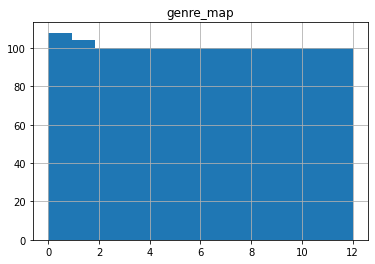

In [61]:
hist_df = final_training_df.copy()
value_counts = cleaned_df['genre'].value_counts()
genre_map = dict()
i = 0
for index,value in value_counts.items(): 
    genre_map[index] = i
    i += 1
print(genre_map)
hist_df['genre_map'] = hist_df['genre'].apply(lambda x: genre_map[x])
hist_df.hist(column='genre_map', bins=len(genre_map))

# Part 3, Add feedback 

In [71]:
fb_df = download_feedback_data('1590302222')
train_df = final_training_df[['genre', 'description']]
final_df = pd.concat([fb_df, train_df], ignore_index=True)

In [72]:
final_df.head()

,description,genre
0,Sherlock Holmes,__label__crime
1,blah,__label__mystery___detective
2,ofuhsdfuhsdf aosudhaposfdh d;foihsodgfsfg,__label__action___adventure
3,nominated as one of america s best loved novel...,__label__thrillers
4,why do smart people make irrational decisions ...,__label__personal_growth


# Part 2, Make Train Test Split

In [73]:
data_labels = final_df['genre'] + '\t' + final_df['description']
train_percentage = 0.8
test_percentage = 1.0 - train_percentage
train_data = data_labels.sample(frac=train_percentage).to_csv('train_genre.txt', header=False, index=False)
test_df = data_labels.sample(frac=test_percentage).to_csv('test_genre.txt', header=False, index=False)

# Part 3, Train Model and Test: this time with some hyperparameter tuning

In [75]:
import fasttext

model = fasttext.train_supervised('train_genre.txt')
for i in range(4): 
    samples, precision, recall = model.test('test_genre.txt', k=i+1)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Top n: {i+1} Samples: {samples} Precision: {precision} Recall: {recall} F1: {f1_score}")

Top n: 1 Samples: 263 Precision: 0.21292775665399238 Recall: 0.21292775665399238 F1: 0.21292775665399238
Top n: 2 Samples: 263 Precision: 0.17870722433460076 Recall: 0.3574144486692015 F1: 0.238276299112801
Top n: 3 Samples: 263 Precision: 0.13688212927756654 Recall: 0.41064638783269963 F1: 0.20532319391634982
Top n: 4 Samples: 263 Precision: 0.15494296577946767 Recall: 0.6197718631178707 F1: 0.2479087452471483


Now let's do a random prediction of a number of inputs

In [76]:
def printout_predictions(model): 
    test_non_df = pd.read_csv('none_genres.csv')
    # pick some random indexes
    randoms = []
    for _ in range(5): 
        randoms.append(random.randint(0, len(test_non_df)))

    for i in range(len(test_non_df)):     
        test_descr = test_none_df.iloc[i]['description']
        cleaned_test = aggressively_clean_text(test_descr)
        prediction = model.predict(cleaned_test)
        print(f"{i}: {cleaned_test[:100]}, prediction: {prediction}")

## Let's go one step further and use fastText's auto hyperparameter tuning with the test file

In [77]:
import fasttext

model = fasttext.train_supervised('train_genre.txt', autotuneValidationFile='test_genre.txt')
for i in range(4): 
    samples, precision, recall = model.test('test_genre.txt', k=i+1)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Top n: {i+1} Samples: {samples} Precision: {precision} Recall: {recall} F1: {f1_score}")

Top n: 1 Samples: 263 Precision: 0.7376425855513308 Recall: 0.7376425855513308 F1: 0.7376425855513308
Top n: 2 Samples: 263 Precision: 0.4752851711026616 Recall: 0.9505703422053232 F1: 0.6337135614702155
Top n: 3 Samples: 263 Precision: 0.32953105196451205 Recall: 0.9885931558935361 F1: 0.49429657794676807
Top n: 4 Samples: 263 Precision: 0.24904942965779467 Recall: 0.9961977186311787 F1: 0.3984790874524715


In [111]:
printout_predictions(model)

0: no safe place left at great cost to the garrison and the survey corps  commander erwin has managed t, prediction: (('__label__fantasy',), array([0.58589464]))
1: with swollen feet and swelling belly  pregnant ellie bravely joins the nation s tourists in seeing t, prediction: (('__label__mystery___detective',), array([0.94599605]))
2: hbo s hit series a game of thrones is based on george r  r  martin s internationally bestselling ser, prediction: (('__label__action___adventure',), array([0.50901055]))
3: agatha christie s first ever murder mystery  with impeccable timing hercule poirot  the renowned bel, prediction: (('__label__classics',), array([0.71170104]))
4: a bundle of books  1  once gone  and  2  once taken  in blake pierce s riley paige mystery series a , prediction: (('__label__mystery___detective',), array([0.50813937]))
5: a classic agatha christie short story  available individually for the first time as an ebook  sir al, prediction: (('__label__mystery___detective',), a

102: the last few decades have seen an explosion in the production of critical theories  with deconstruct, prediction: (('__label__general',), array([0.99406332]))
103:  a must read  mark manson   exactly what most of us need in order to focus on what is important  rat, prediction: (('__label__general',), array([0.99376738]))
104: why do some people achieve all their goals while others simply dream of having a better life  with o, prediction: (('__label__motivational',), array([0.54648149]))
105: this carefully crafted ebook   the art of war  the classic lionel giles translation   is formatted f, prediction: (('__label__general',), array([0.99162292]))
106: how will you determine if your company has succeeded if you can t base its performance on a well def, prediction: (('__label__motivational',), array([0.96693969]))
107: where does that  winning edge  you ve heard so much about come from  how do some people seem to find, prediction: (('__label__personal_growth',), array([0.76611388])

193: do you buy things without need do you buy things to feel happy  if the answer is  yes  then you need, prediction: (('__label__personal_finance',), array([0.58333361]))
194: the justice league is dead  and the villains shall inherit the earth  in a flash of light  the world, prediction: (('__label__superheroes',), array([0.99974042]))
195:  an all too plausible disaster for the world we live in  great nail biting stuff    robert goddard  , prediction: (('__label__crime',), array([0.62200481]))
196:  a masterpiece of thriller and mystery  blake pierce did a magnificent job developing characters wit, prediction: (('__label__mystery___detective',), array([0.90371966]))
197: letting go describes a simple and effective means by which to let go of the obstacles to enlightenme, prediction: (('__label__general',), array([0.45930874]))
198:  an action packed fantasy sure to please fans of morgan rice s previous novels  along with fans of w, prediction: (('__label__science_fiction',), array(

260: the  1 new york times bestselling biography of how steve jobs became the most visionary ceo in histo, prediction: (('__label__general',), array([0.6315791]))
261:  i have stolen princesses back from sleeping barrow kings  i burned down the town of trebon  i have , prediction: (('__label__fantasy',), array([0.93514502]))
262:  astonishing     an amazing book     absolutely chocker full of things that we need to know  chris e, prediction: (('__label__general',), array([0.64317286]))
263: the future looks bright when brilliant and benevolent dr  light unveils his latest creations  the ro, prediction: (('__label__fantasy',), array([0.81269109]))
264: the last few decades have seen an explosion in the production of critical theories  with deconstruct, prediction: (('__label__general',), array([0.99406332]))
265: where does that  winning edge  you ve heard so much about come from  how do some people seem to find, prediction: (('__label__personal_growth',), array([0.76611388]))
266:  an 

AttributeError: 'float' object has no attribute 'lower'

### This is like... orders of magnitude awesomely better. 

Let's save this model so that we can use it later! We'll give it a descriptive name. 

In [112]:
from datetime import datetime as dt
timestamp = dt.now().strftime('%s')
model_name = 'genre_class_' + timestamp + '.bin'
model.save_model(model_name)

But what was this model actually trained with? 'dump' exists as an option for fasttext as a command line option, but what about Python? 

Other features we could train with: 
- the title 
- the author 
- publisher

In [106]:
pred_labels, confids = model.predict("woot woot thriller", k=5)

In [108]:
zip(pred_labels, confids)

In [110]:
for label,confidence in zip(pred_labels, confids): 
    print(f"Label: {label}, confidence: {confidence}")

Label: __label__thrillers, confidence: 0.9975988864898682
Label: __label__crime, confidence: 0.0024166591465473175
Label: __label__mystery___detective, confidence: 1.4523980098601896e-05
Label: __label__action___adventure, confidence: 1.000365682557458e-05
Label: __label__horror, confidence: 1.0000613656302448e-05


In [113]:
model_ = fasttext.load_model('genre_class_1590302222.bin')

In [114]:
model_.predict('help')

(('__label__personal_finance',), array([0.34182847]))

In [115]:
print(confids)

[9.97598886e-01 2.41665915e-03 1.45239801e-05 1.00036568e-05
 1.00006137e-05]


In [118]:
print(list(pred_labels))

['__label__thrillers', '__label__crime', '__label__mystery___detective', '__label__action___adventure', '__label__horror']
